In [2]:
#import package
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pylab as plt
import time

from keras.models import Sequential, Model
from keras.layers import Input, RepeatVector, Merge
from keras.layers.core import Dense, Dropout, Activation 
from keras.layers.recurrent import LSTM, GRU
from keras import optimizers

%matplotlib inline

print('Done')

Using TensorFlow backend.


Done


In [63]:
def readData():
    data = pd.read_csv('C:/Users/yoon/Python/Stock_Prediction/data/Samsung_20_DIV.csv', parse_dates = [0])
    raw_dates = data.loc[30:, 'date'].reset_index(drop=True)
    del data['date']
    raw_data = data.loc[30:].reset_index(drop=True)
    return raw_data, raw_dates

def split_into_chunks(data, train, predict, step):
    train_set, label_set = [], []
        
    for i in range(0, len(data), step):
        try:  
            temp_train = data.loc[i:i+train-1, 'dSMA':'dCCI'].as_matrix()
            #temp_train = preprocessing.scale(temp_train)
            temp_label = 0;
            for j in range(1, 11):
                temp_label = temp_label + data.loc[i+train-1+predict, 'return']
            if temp_label > 0:
                temp_label = 1.0
            else:
                temp_label = 0.0
        except:
            break
        train_set.append(temp_train)
        label_set.append(temp_label)
    
    return train_set, label_set

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    return a, b

def create_Xt_Yt(X, y, percentage=0.8):
#    X, y = shuffle_in_unison(X, y)
    X_train1 = X[0:int(len(X) * percentage)]
    X_train2 = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
#    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
    X_test1 = X[int(len(X) * percentage):]
    X_test2 = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]
    return X_train1, X_train2, Y_train, X_test1, X_test2, Y_test

print('Done')

Done


In [64]:
timeSeriesList, dates = readData()
TIMESTEPS = 10
TARGET_TIME = 1
STEP_SIZE = 1
EMB_SIZE = 10

print('Done')

Done


In [65]:
X, Y = split_into_chunks(timeSeriesList, TIMESTEPS, TARGET_TIME, STEP_SIZE)
X, Y = np.array(X), np.array(Y)
#X = X.reshape(-1, DATA_SIZE_ON_TRAIN * 10)
X_train1, X_train2, Y_train, X_test1, X_test2, Y_test = create_Xt_Yt(X, Y)

print('Done')

Done


In [66]:
encoder_A = Sequential()
encoder_A.add(LSTM(16, return_sequences=False, input_shape=(TIMESTEPS, EMB_SIZE)))

encoder_B = Sequential()
encoder_B.add(LSTM(16, return_sequences=False, input_shape=(TIMESTEPS, EMB_SIZE)))

decoder = Sequential()
decoder.add(Merge([encoder_A, encoder_B], mode = 'concat'))
decoder.add(Dense(1, activation = 'sigmoid'))

decoder.compile(optimizer='adam', loss='mse',
               metrics=['accuracy'])
print("done")

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:8: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


done


In [67]:
print("Training...")
decoder.fit([X_train1, X_train2], 
            Y_train, 
            epochs = 10,
            batch_size = 128,
            verbose=1)

print("Evaluating...")
score = decoder.evaluate([X_test1, X_test2], Y_test, batch_size=128)
print("\nTest loss and accuracy:" + str(score))
print('Done')

Training...
Epoch 1/10
4142/4142 [==============================] - 19s - loss: 0.2500 - acc: 0.5181    
Epoch 2/10
4142/4142 [==============================] - 2s - loss: 0.2472 - acc: 0.5493     
Epoch 3/10
4142/4142 [==============================] - 2s - loss: 0.2465 - acc: 0.5577     
Epoch 4/10
4142/4142 [==============================] - 2s - loss: 0.2461 - acc: 0.5555     
Epoch 5/10
4142/4142 [==============================] - 2s - loss: 0.2458 - acc: 0.5616     
Epoch 6/10
4142/4142 [==============================] - 2s - loss: 0.2454 - acc: 0.5637     
Epoch 7/10
4142/4142 [==============================] - 2s - loss: 0.2452 - acc: 0.5594     
Epoch 8/10
4142/4142 [==============================] - 2s - loss: 0.2447 - acc: 0.5640     
Epoch 9/10
4142/4142 [==============================] - 2s - loss: 0.2444 - acc: 0.5662     
Epoch 10/10
4142/4142 [==============================] - 2s - loss: 0.2441 - acc: 0.5652     
Evaluating...
1036/1036 [==============================] 

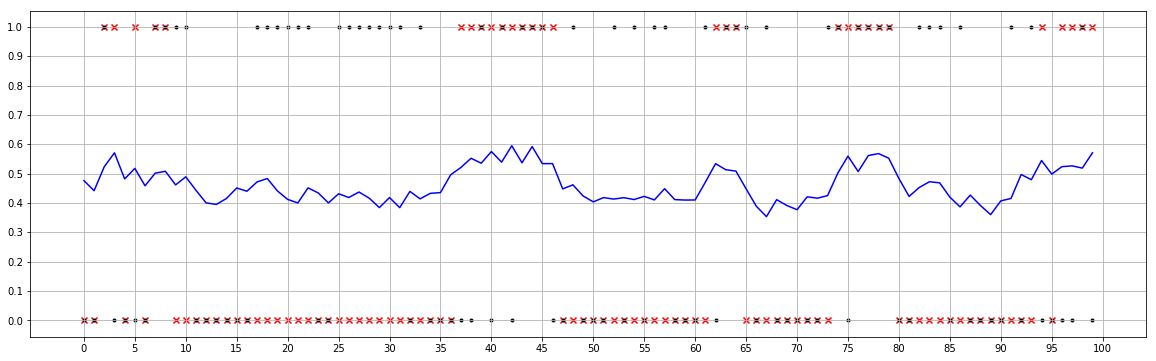

In [68]:
predicted = decoder.predict([X_test1, X_test2])
plt.figure(figsize=(20, 6))
plt.xticks(np.arange(0,101,5))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True)
plt.plot(range(0,100), predicted[:100], color='blue')
plt.scatter(range(0,100),predicted[:100].round(), color='red', marker='x')
plt.scatter(range(0,100), Y_test[:100], color='black', marker='.')